In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from pyod.models.mcd import MCD
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(47); plt.style.use('dark_background')
plt.rc('axes', titlesize=24, labelsize=20, labelpad=5)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)              
plt.rc('legend', fontsize=12)

In [2]:
# Define the true binomial Gaussian distribution
mean = [2, 2]
cov = [[1, 0.5], [0.5, 1]]

# Generate sample data and define anomaly classes
data = np.random.multivariate_normal(mean, cov, 500)
anomaly_classes = [(-1, 5), (5, -1), (-2, 2), (6, 6), 
             (-3, 2), (2, -3), (8, 2), (2, 8)]

anomalies = [
    (x + np.random.normal(0, 1), y + np.random.normal(0, 1))
    for _ in range(3) for x, y in anomaly_classes
]

In [3]:
df = pd.DataFrame(data, columns=['f1', 'f2'])
df['unknown_anomalous'] = 0
anomalies_df = pd.DataFrame(
    map(lambda x: list(x) + [1], anomalies), 
    columns=['f1', 'f2', 'unknown_anomalous']
)
df = pd.concat([df, anomalies_df], axis=0, ignore_index=True)
df['unknown_anomalous'] = (
    df['unknown_anomalous'].astype('category')
)
df.sample(5)

,f1,f2,unknown_anomalous
396,1.787440,0.792185,0
373,2.745891,2.337959,0
432,3.288968,2.440845,0
83,1.138606,4.090672,0
361,3.271214,2.531483,0


In [4]:
# Train-test split
X = df.drop('unknown_anomalous', axis=1)
y = df['unknown_anomalous']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(X_train.shape)
print(X_test.shape)

(366, 2)
(158, 2)


In [5]:
mcd = MCD()
mcd.fit(X_train)
y_pred_train = mcd.predict(X_train)
y_pred_test = mcd.predict(X_test)
X_test['predicted_anomalous'] = y_pred_test

In [6]:
rv = multivariate_normal(mean, cov)
h = 0.02
x_min, x_max = [-1, 5]
y_min, y_max = [-1, 5]
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
zz = rv.pdf(np.dstack((xx, yy)))

# Create meshgrid for decision boundary visualization
x_min, x_max = -5, 9
y_min, y_max = -5, 9
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
pairs = np.c_[xx.ravel(), yy.ravel()]

# Get decision function and predicted labels for the meshgrid
zz = mcd.decision_function(pairs).reshape(xx.shape)
zz2 = mcd.predict(pairs).reshape(xx.shape)

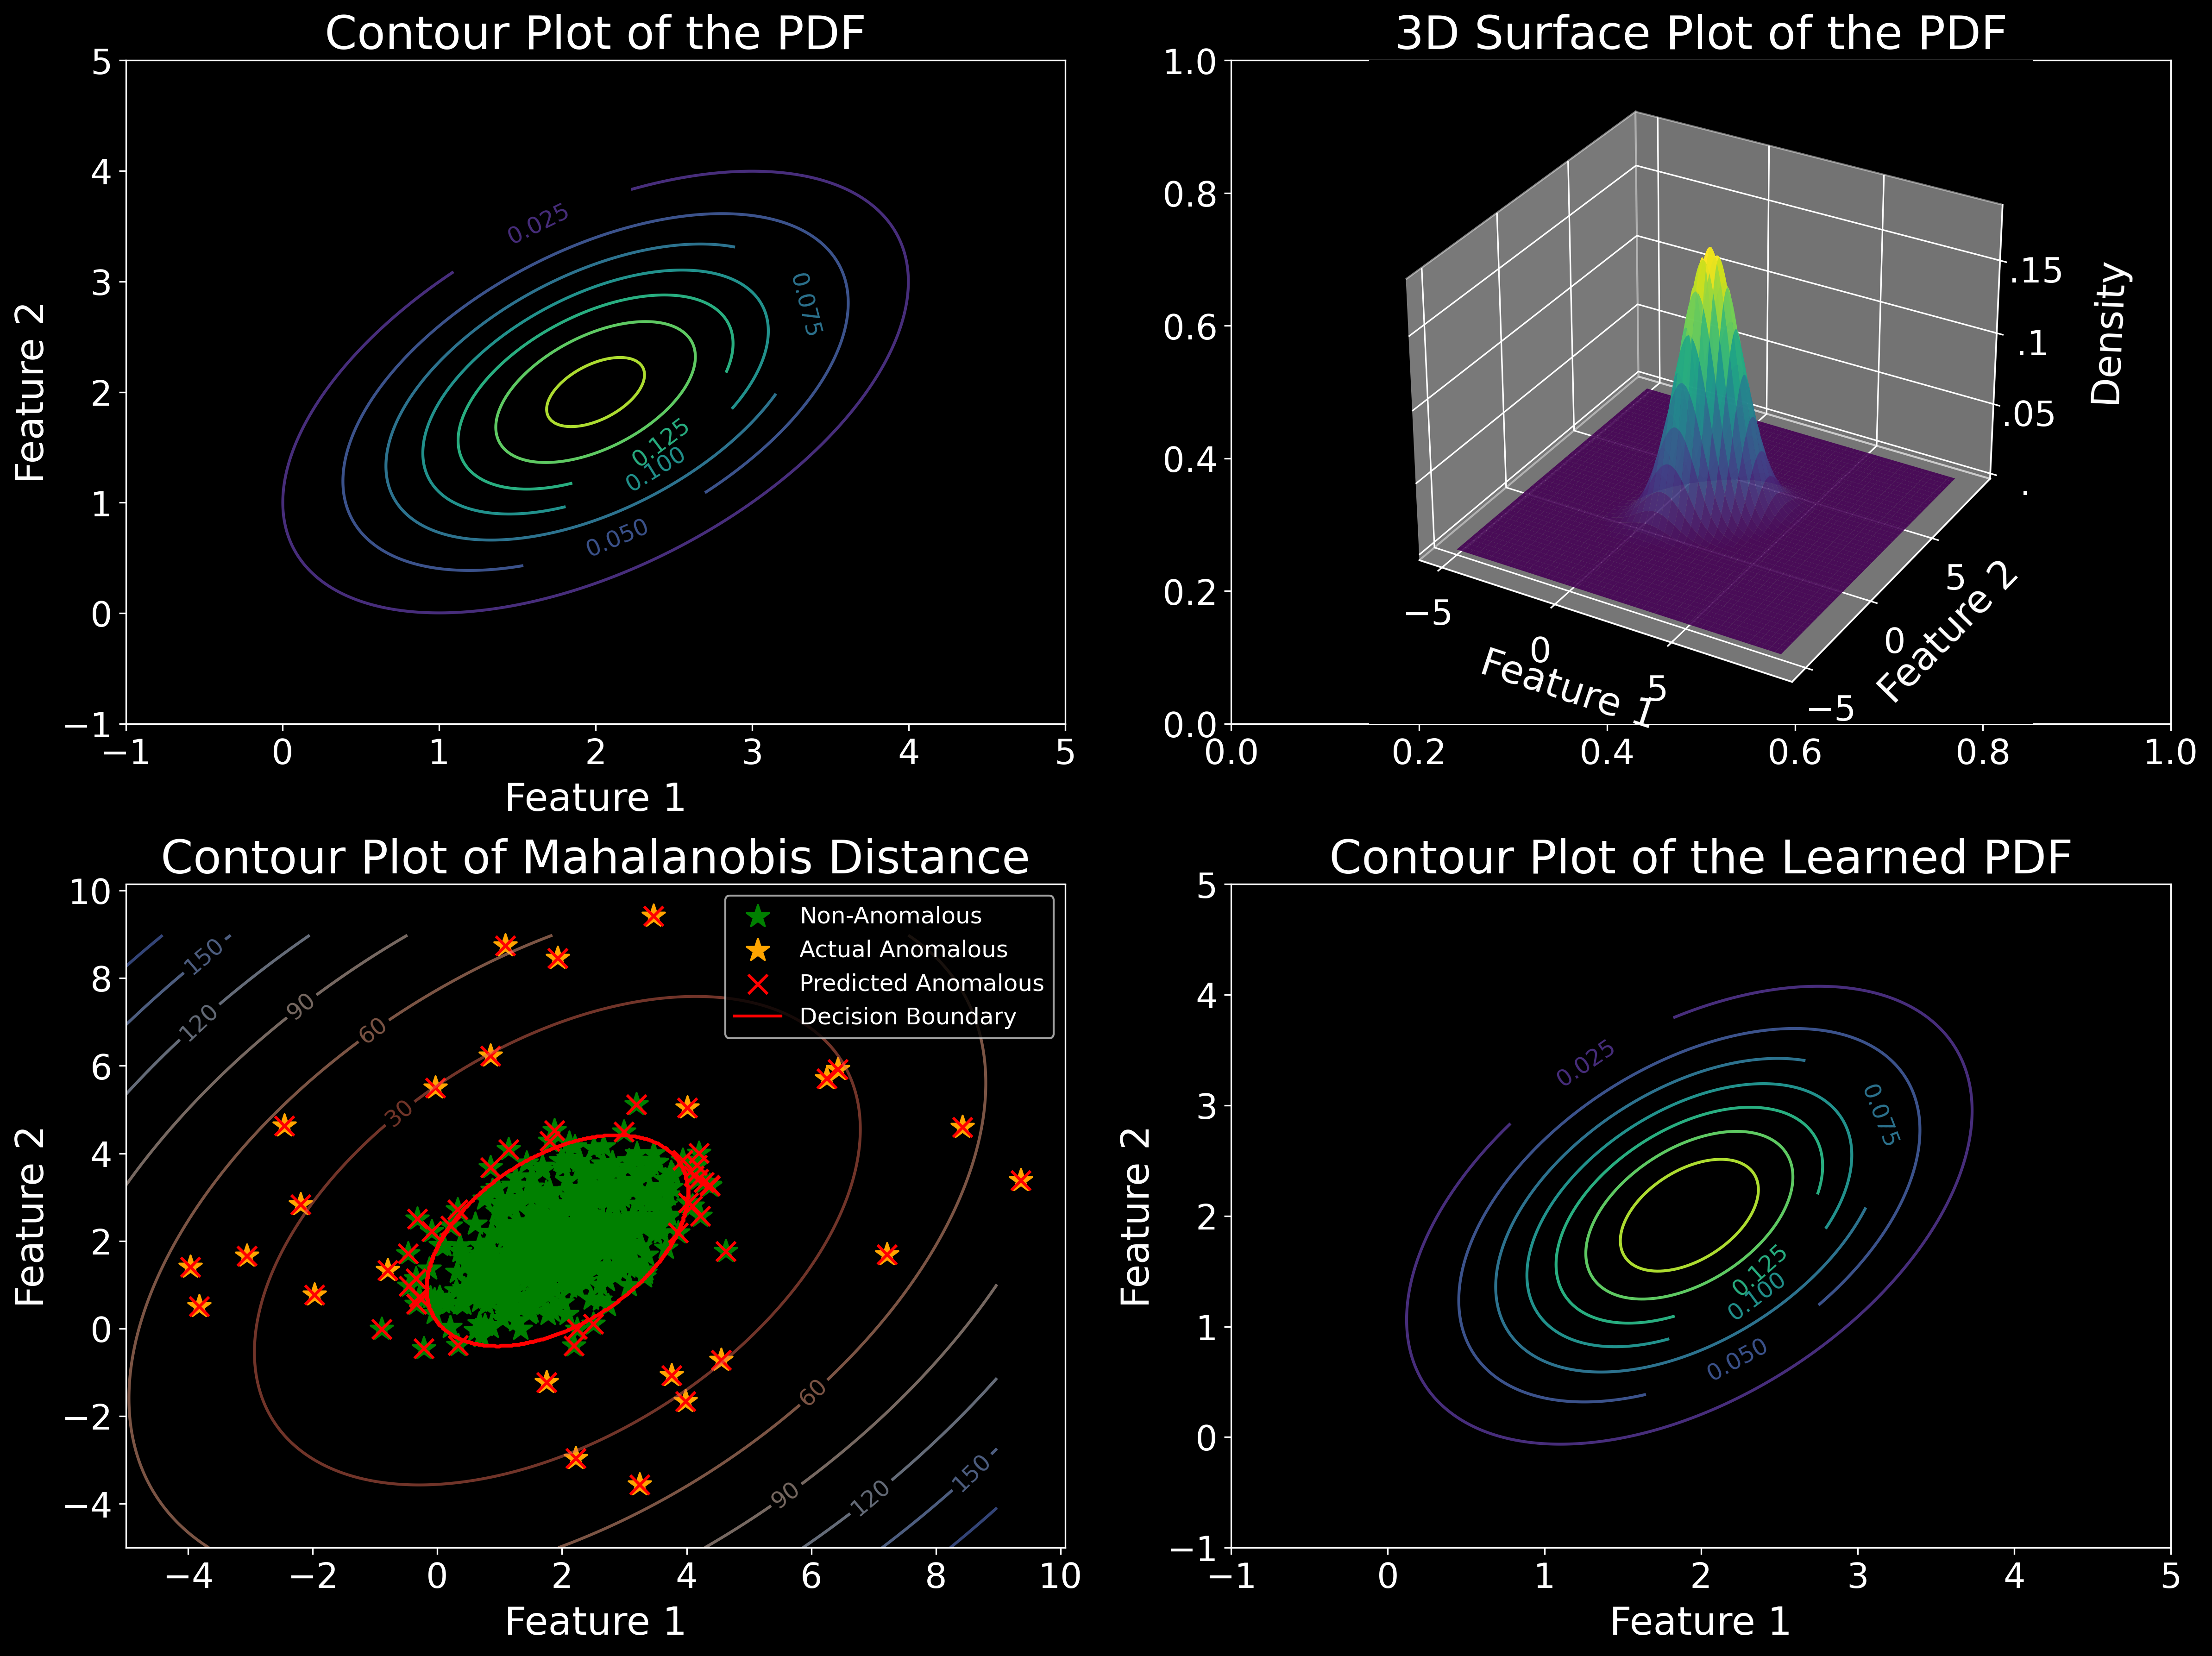

In [7]:
# Create a 2x2 figure layout
fig, axs = plt.subplots(2, 2, figsize=(16, 12), dpi=300)

# Contour plot on the first axis (actual joint probability density)
cs = axs[0, 0].contour(xx, yy, rv.pdf(np.dstack((xx, yy))), cmap='viridis', alpha=1)
axs[0, 0].clabel(cs, inline=True, fontsize=12)
axs[0, 0].set_xlabel('Feature 1')
axs[0, 0].set_ylabel('Feature 2')
axs[0, 0].set_title('Contour Plot of the PDF')
axs[0, 0].set_xlim(-1, 5)
axs[0, 0].set_ylim(-1, 5)

# 3D Surface plot on the second axis
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_surface(xx, yy, rv.pdf(np.dstack((xx, yy))), cmap='viridis', alpha=0.9)
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Density', labelpad=15)
ax2.set_title('3D Surface Plot of the PDF')
ax2.zaxis.set_major_formatter(lambda x, y: f'{x:.2f}'.strip('0'))

# Decision boundary with predicted labels on the third axis
cs1 = axs[1, 0].contour(xx, yy, zz, cmap='coolwarm_r', alpha=0.5)
axs[1, 0].contour(xx, yy, zz2, colors='red')  # Plot contour without label here
axs[1, 0].clabel(cs1, inline=True, fontsize=12)
axs[1, 0].scatter(X.iloc[:, 0][y == 0], X.iloc[:, 1][y == 0], c='g', edgecolors='g', marker='*', label='Non-Anomalous', s=150)
axs[1, 0].scatter(X.iloc[:, 0][y == 1], X.iloc[:, 1][y == 1], c='orange', marker='*', label='Actual Anomalous', s=150)
axs[1, 0].scatter(X.iloc[:, 0][mcd.predict(X) == 1], X.iloc[:, 1][mcd.predict(X) == 1], c='r', marker='x', label='Predicted Anomalous', s=100)
axs[1, 0].set_title('Contour Plot of Mahalanobis Distance')
axs[1, 0].set_xlabel('Feature 1')
axs[1, 0].set_ylabel('Feature 2')
proxy_contour = plt.Line2D([], [], color='red', linestyle='-', label='Decision Boundary')
axs[1, 0].legend(handles=axs[1, 0].get_legend_handles_labels()[0] + [proxy_contour])

# Learned PDF contour plot on the fourth axis
learned_covariance_matrix = mcd.covariance_
means = mcd.location_
zz_learned = multivariate_normal.pdf(np.dstack((xx, yy)), mean=means, cov=learned_covariance_matrix)
cs2 = axs[1, 1].contour(xx, yy, zz_learned, levels=cs.levels, cmap='viridis', alpha=1)
axs[1, 1].clabel(cs2, inline=True, fontsize=12)
axs[1, 1].set_title('Contour Plot of the Learned PDF', fontsize=24)
axs[1, 1].set_xlabel('Feature 1')
axs[1, 1].set_ylabel('Feature 2')
axs[1, 1].set_xlim(-1, 5)
axs[1, 1].set_ylim(-1, 5)

# Display the plots
plt.tight_layout(pad=1)
plt.show()

In [8]:
# Evaluate and print the balanced acc. score for the test set
test_score = balanced_accuracy_score(y_test, y_pred_test)
print(f"Balanced Acc. Score (Test Set): {test_score:.4f}")
train_score = balanced_accuracy_score(y_train, y_pred_train)
print(f"Balanced Acc. Score (Training Set): {train_score:.4f}")
print("MCD Model Location (Mean):")
print(mcd.location_)
print("MCD Model Covariance Matrix:")
print(mcd.covariance_)

Balanced Acc. Score (Test Set): 0.9597
Balanced Acc. Score (Training Set): 0.9687
MCD Model Location (Mean):
[1.92562557 2.00668263]
MCD Model Covariance Matrix:
[[0.78780055 0.41237573]
 [0.41237573 1.03616725]]
